# Data Visualization

In [37]:
import pandas as pd
import numpy as np
import os
import utilities as utils
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances;
%matplotlib widget

In [38]:
import importlib
importlib.reload(utils)

<module 'utilities' from '/Users/zeyadahmed/Documents/UPEI/2024W/CS4440/Project/ml2/Bacteria-Classification-ML/utilities.py'>

In [40]:
import gc
gc.collect()

0

In [41]:
dataset = 'patho_repr'

In [42]:
labels = []
cgr_mats = []
seqs = []
#cgr_flattened = []
for dir1 in [dir for dir in os.listdir(dataset) if not dir.startswith('.')]:
    for file in os.listdir(os.path.join(dataset, dir1)):
        path_to_file = os.path.join(dataset,dir1,file)
        sequence = utils.read_sequence(path_to_file)
        seqs.append(sequence)
        sequence_reverse_complement = utils.reverse_complement(sequence)
        #tmp = utils.cgr(sequence, 'ACGT', 7)
        tmp = utils.cgr(sequence, 'ACGT', 6) + utils.cgr(sequence_reverse_complement, 'ACGT', 6)
        cgr_mats.append(tmp)
        labels.append(path_to_file.split('/')[1])
        #cgr_flattened.append(tmp.flatten())

print(np.array(labels).shape)

(138,)


In [43]:
new_cgrs = []
new_labs = []
for lab in np.unique(labels):
    idxs = np.where(np.array(labels) == lab)[0]
    new_labs.append(lab)
    new_cgrs.append(np.sum(np.array(cgr_mats)[idxs], axis=0))
vector_cgrs = [mat.flatten() for mat in new_cgrs]
print(np.array(new_cgrs).shape)

(44, 64, 64)


In [44]:
normalized_mats = [mat/np.max(mat) for mat in new_cgrs]
vector_cgrs = [mat.flatten() for mat in normalized_mats]

In [45]:
np.array(normalized_mats).shape

(44, 64, 64)

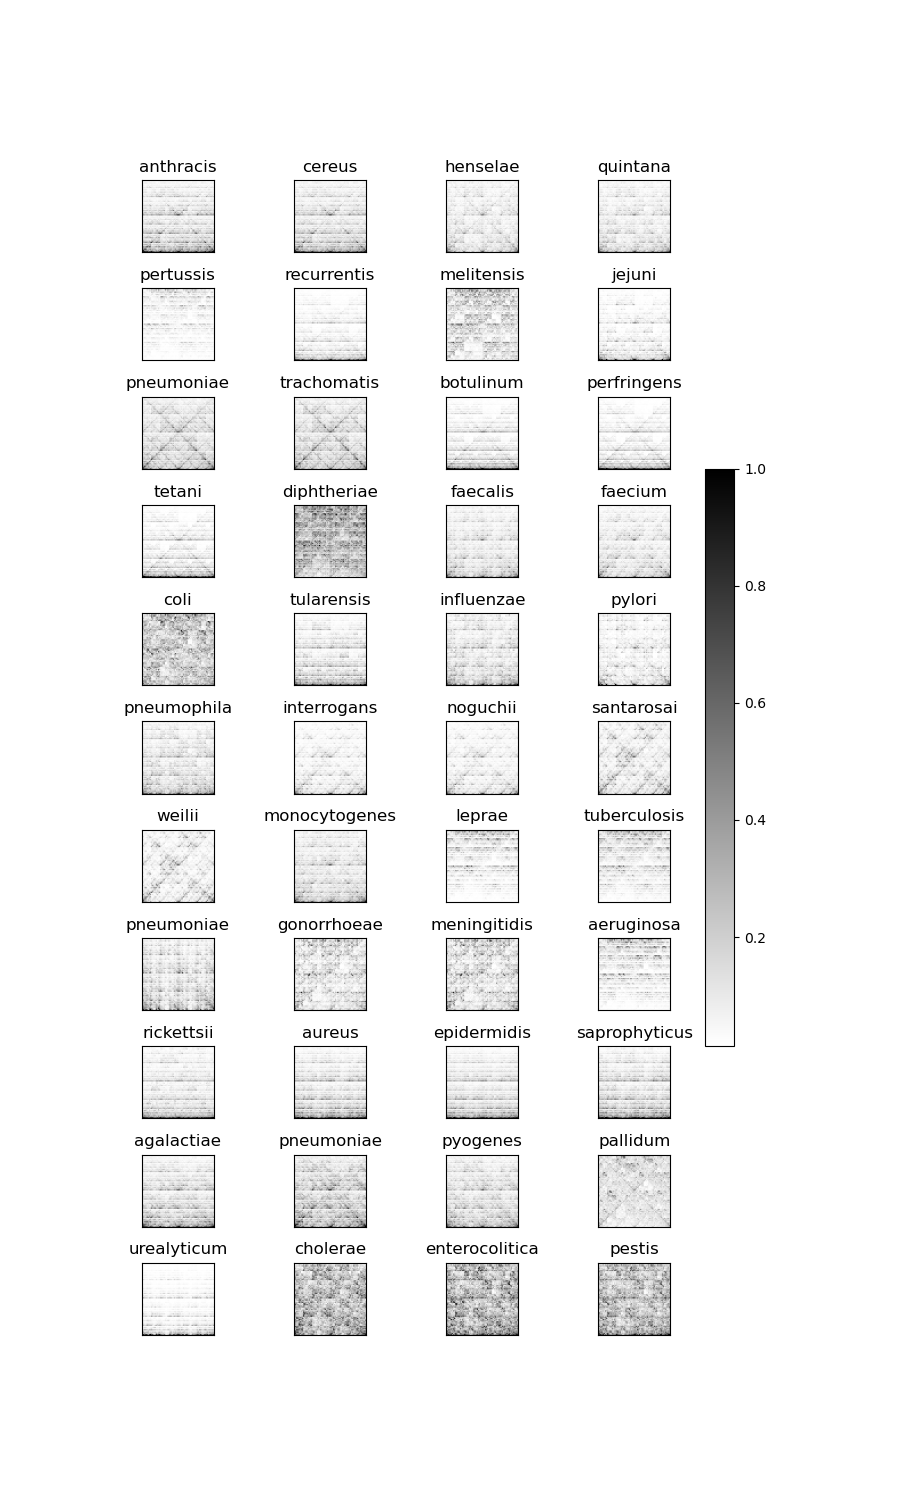

In [46]:
fig,ax = plt.subplots(11,4, figsize=(9,15))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
ax_flat = ax.flatten()
for axs,cgr,lab in zip(ax_flat, normalized_mats, new_labs):
    axs.set_title(lab.split('_')[-1])
    axs.set_xticks([])
    axs.set_yticks([])
    plot = axs.imshow(cgr, cmap='gray_r')
fig.colorbar(plot, ax=ax, shrink=0.5)
plt.show()


In [47]:
D = pairwise_distances(vector_cgrs, metric='manhattan')

In [48]:
np.all(np.diag(D) == 0)

True

In [49]:
np.all(D == D.T)

True

In [50]:
reduced = utils.perform_mds(D, 3, random_state=0)

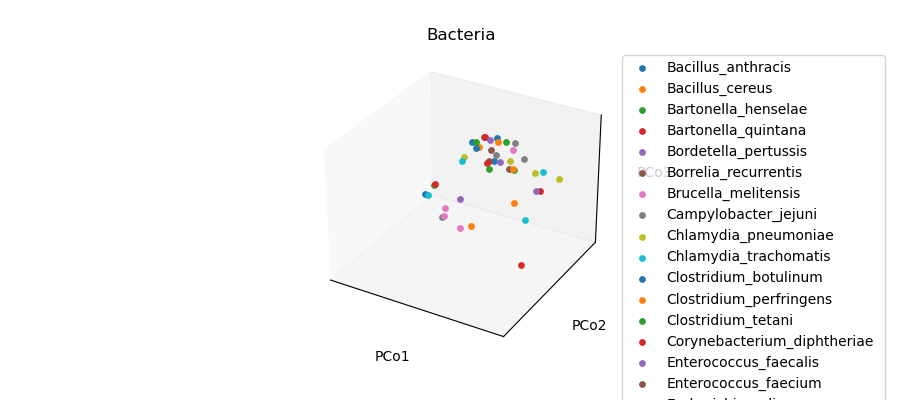

In [51]:
utils.plot_3d(reduced, new_labs)

In [66]:
normalized_mats = [(mat-np.mean(mat))/np.std(mat) for mat in cgr_mats]
vector_cgrs = [mat.flatten() for mat in normalized_mats]
vector_cgrs = np.array([mat.flatten() for mat in normalized_mats])

In [67]:
from sklearn.decomposition import PCA

# Perform PCA
pca = PCA(n_components=3)
pca.fit(vector_cgrs)

# Transform the data to its principal components
transformed_data = pca.transform(vector_cgrs)
comp1 = transformed_data[:, 0]

In [68]:
at_content = [(seq.count('C')+seq.count('G'))/len(seq) for seq in seqs]

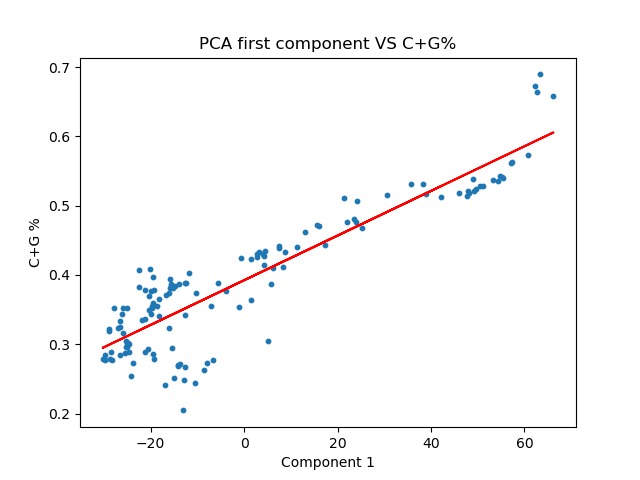

In [69]:
plt.figure()
plt.scatter(comp1, at_content, s=10)
plt.title('PCA first component VS C+G%')
slope, intercept = np.polyfit(comp1, at_content, 1)
plt.xlabel('Component 1')
plt.ylabel('C+G %')
plt.plot(comp1, slope*comp1+intercept, c='r')
plt.show()

In [70]:
label_map = {label: i for i,label in enumerate(np.unique(labels))}
dummy_labels = np.array([label_map[lab] for lab in labels])
numerical_to_label = {val: key for key,val in label_map.items()}

print(numerical_to_label)

{0: 'Bacillus_anthracis', 1: 'Bacillus_cereus', 2: 'Bartonella_henselae', 3: 'Bartonella_quintana', 4: 'Bordetella_pertussis', 5: 'Borrelia_recurrentis', 6: 'Brucella_melitensis', 7: 'Campylobacter_jejuni', 8: 'Chlamydia_pneumoniae', 9: 'Chlamydia_trachomatis', 10: 'Clostridium_botulinum', 11: 'Clostridium_perfringens', 12: 'Clostridium_tetani', 13: 'Corynebacterium_diphtheriae', 14: 'Enterococcus_faecalis', 15: 'Enterococcus_faecium', 16: 'Escherichia_coli', 17: 'Francisella_tularensis', 18: 'Haemophilus_influenzae', 19: 'Helicobacter_pylori', 20: 'Legionella_pneumophila', 21: 'Leptospira_interrogans', 22: 'Leptospira_noguchii', 23: 'Leptospira_santarosai', 24: 'Leptospira_weilii', 25: 'Listeria_monocytogenes', 26: 'Mycobacterium_leprae', 27: 'Mycobacterium_tuberculosis', 28: 'Mycoplasma_pneumoniae', 29: 'Neisseria_gonorrhoeae', 30: 'Neisseria_meningitidis', 31: 'Pseudomonas_aeruginosa', 32: 'Rickettsia_rickettsii', 33: 'Staphylococcus_aureus', 34: 'Staphylococcus_epidermidis', 35: 'S

In [34]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [35]:
clf_rf = RandomForestClassifier(criterion='gini',max_depth=19)
FOLDS = 10
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=99)

In [36]:
accs_rf = []
for train_i, test_j in kf.split(vector_cgrs):
    X_train, X_test = vector_cgrs[train_i], vector_cgrs[test_j]
    y_train, y_test = np.array(patho_labs)[train_i], np.array(patho_labs)[test_j]
    clf_rf.fit(X_train, y_train)
    y_preds = clf_rf.predict(X_test)
    accuracy = 100*accuracy_score(y_test, y_preds)
    accs_rf.append(accuracy)

TypeError: only integer scalar arrays can be converted to a scalar index

In [ ]:
for i,score in enumerate(accs_rf):
    print(f'Fold {i+1}: {score}')